In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.9 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from google.colab import files
uploaded = files.upload()
df = pd.read_csv("imputed_dataset (1).csv")
df.head()

Saving imputed_dataset (1).csv to imputed_dataset (1).csv


,id,water,sunlight,temperature,fertilizer,area,soil_quality,rainfall,yield
0,1.0,150.000000,8.000000,22.000000,30.462077,105.0,7.433121,100.0,3.3
1,2.0,150.000000,7.969988,22.000000,28.000000,130.0,9.000000,112.0,4.1
2,3.0,160.000000,9.000000,24.000000,28.000000,130.0,8.000000,104.0,3.0
3,4.0,160.669014,8.000000,24.027578,30.462077,105.0,8.000000,105.0,3.9
4,5.0,160.000000,7.000000,24.000000,31.000000,110.0,6.000000,100.0,3.0


In [ ]:

df_features = df.drop(columns=['id', 'yield'])
df_target = df['yield'].values.reshape(-1, 1)

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(df_features)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_target)

X_all = X_scaled
y_all = y_scaled

In [ ]:
k = 5
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_all)

edge_index_list = []
for i in range(len(X_all)):
    _, indices = knn.kneighbors([X_all[i]])
    for j in indices[0]:
        if i != j:
            edge_index_list.append([i, j])
            edge_index_list.append([j, i])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
x = torch.tensor(X_all, dtype=torch.float)
y = torch.tensor(y_all, dtype=torch.float)


In [ ]:

train_idx, test_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=42)
train_mask = torch.zeros(len(y), dtype=torch.bool)
test_mask = torch.zeros(len(y), dtype=torch.bool)
train_mask[train_idx] = True
test_mask[test_idx] = True


In [ ]:

data = Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, test_mask=test_mask)

In [ ]:
class ImprovedGNN(MessagePassing):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__(aggr='mean')
        self.lin1 = nn.Linear(input_dim, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.lin1(x))
        x = self.propagate(edge_index, x=x)
        x = self.dropout(F.relu(self.lin2(x)))
        return self.lin3(x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out):
        return aggr_out

Epoch 0, Loss: 1.0369
Epoch 50, Loss: 0.7976
Epoch 100, Loss: 0.6225
Epoch 150, Loss: 0.5216
Epoch 200, Loss: 0.4644
Epoch 250, Loss: 0.3872


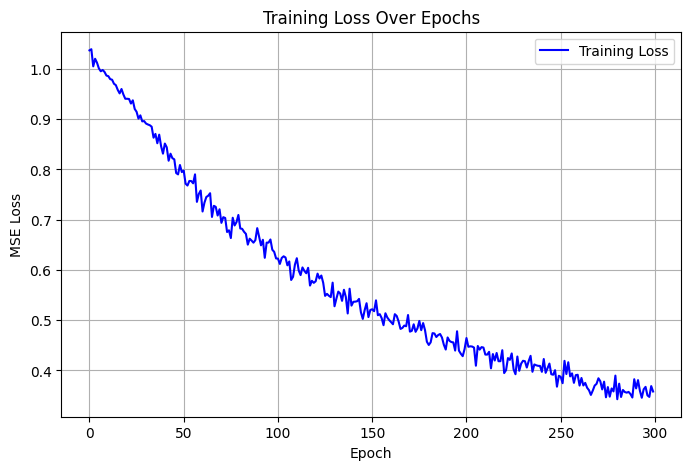

In [ ]:
import matplotlib.pyplot as plt

device = torch.device("cpu")
model = ImprovedGNN(input_dim=x.shape[1], hidden_dim=64, output_dim=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
loss_fn = nn.MSELoss()

train_losses = []

model.train()
for epoch in range(300):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error

model.eval()
with torch.no_grad():

    y_pred = model(data)

    y_pred_inv = scaler_y.inverse_transform(y_pred[data.test_mask].cpu().numpy())
    y_actual_inv = scaler_y.inverse_transform(data.y[data.test_mask].cpu().numpy())


    mse = np.mean((y_pred_inv - y_actual_inv) ** 2)
    rmse = np.sqrt(mse)

    print(f"Mean Squared Error (MSE) on Test Set: {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse:.4f}")


    mae = mean_absolute_error(y_actual_inv, y_pred_inv)
    print(f"Mean Absolute Error (MAE) on Test Set: {mae:.4f}")


Mean Squared Error (MSE) on Test Set: 0.3265
Root Mean Squared Error (RMSE) on Test Set: 0.5714
Mean Absolute Error (MAE) on Test Set: 0.4683


In [ ]:
 for i in range(len(y_pred_inv)):
        print(f"Predicted: {y_pred_inv[i][0]:.4f}, Actual: {y_actual_inv[i][0]:.4f}")

Predicted: 3.1175, Actual: 4.2000
Predicted: 3.1767, Actual: 4.1000
Predicted: 3.5860, Actual: 2.7000
Predicted: 3.6791, Actual: 4.0000
Predicted: 3.4181, Actual: 3.6000
Predicted: 3.9574, Actual: 3.4854
Predicted: 3.4714, Actual: 4.0000
Predicted: 2.8685, Actual: 3.9000
Predicted: 3.5484, Actual: 3.1000
Predicted: 3.3931, Actual: 3.8000
Predicted: 3.1898, Actual: 3.9000
Predicted: 2.9478, Actual: 2.8000
Predicted: 3.4474, Actual: 4.2000
Predicted: 3.2927, Actual: 2.8000
Predicted: 3.3925, Actual: 4.0000
Predicted: 3.7061, Actual: 3.8000
Predicted: 3.3148, Actual: 3.6000
Predicted: 3.4689, Actual: 4.3000
Predicted: 3.5866, Actual: 3.8000
Predicted: 3.7155, Actual: 3.4854
Predicted: 3.4352, Actual: 3.8000
Predicted: 3.3568, Actual: 3.0000
Predicted: 3.8145, Actual: 3.9000
Predicted: 3.2607, Actual: 4.2000
Predicted: 3.5199, Actual: 3.8000
Predicted: 2.9643, Actual: 2.8000
Predicted: 3.0642, Actual: 3.6000
Predicted: 2.8490, Actual: 4.3000
Predicted: 3.7791, Actual: 3.9000
Predicted: 3.7

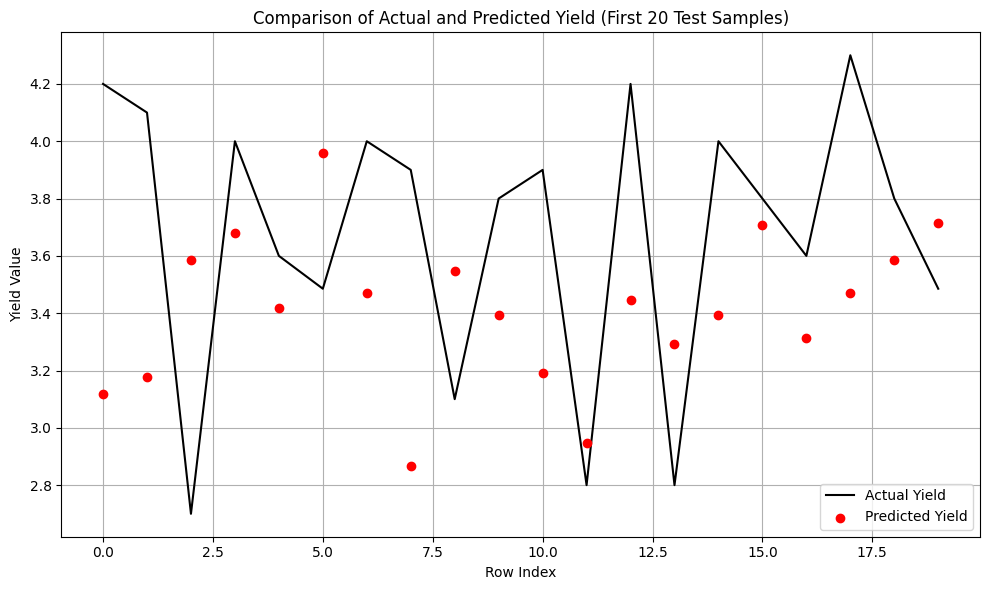

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

n = 20
actual_subset = y_actual_inv[:n].flatten()
pred_subset = y_pred_inv[:n].flatten()

plt.figure(figsize=(10, 6))

plt.plot(range(n), actual_subset, label='Actual Yield', color='black')


plt.scatter(range(n), pred_subset, color='red', label='Predicted Yield', zorder=5)


plt.xlabel("Row Index")
plt.ylabel("Yield Value")
plt.title("Comparison of Actual and Predicted Yield (First 20 Test Samples)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Saving predicted_vs_actual.csv to predicted_vs_actual.csv


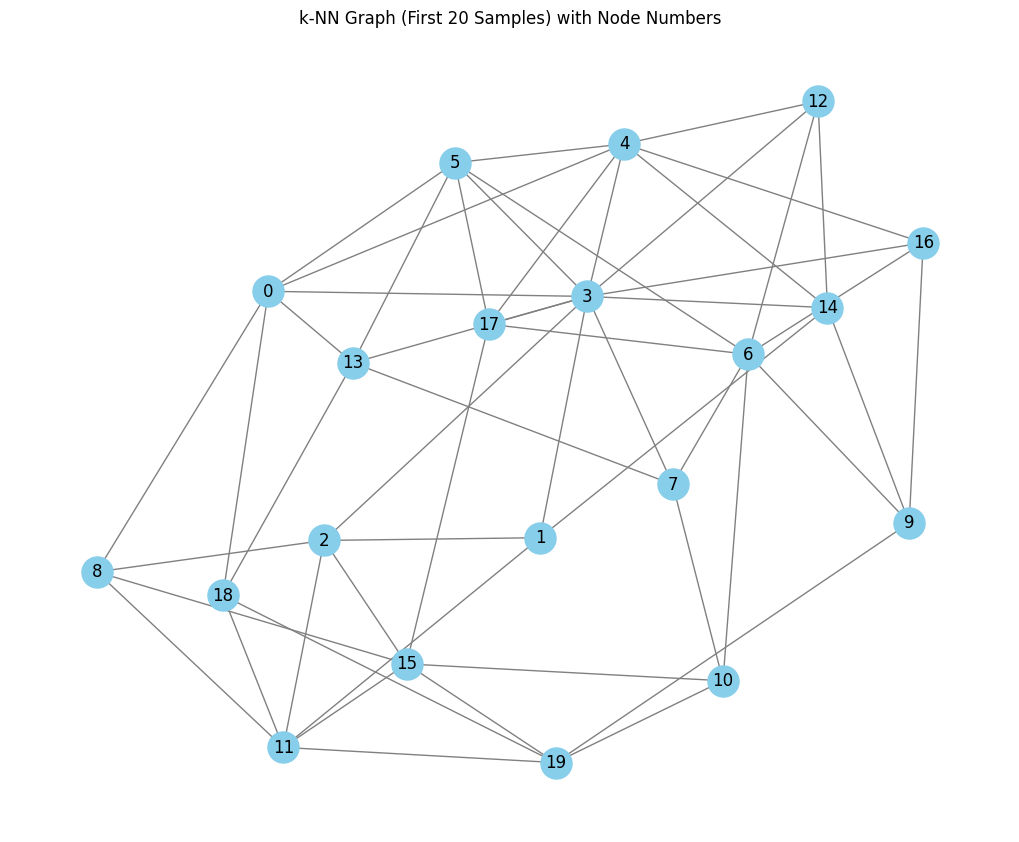

In [ ]:

from torch_geometric.data import Data
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx


uploaded = files.upload()

df = pd.read_csv("imputed_dataset (1).csv")
df_features = df.drop(columns=['id', 'yield'])
df_target = df['yield'].values.reshape(-1, 1)

scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(df_features)
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(df_target)


num_samples = 20
X_subset = X_scaled[:num_samples]
y_subset = y_scaled[:num_samples]

k = 5
knn = NearestNeighbors(n_neighbors=k)
knn.fit(X_subset)

edge_index_list = []
for i in range(len(X_subset)):
    _, indices = knn.kneighbors([X_subset[i]])
    for j in indices[0]:
        if i != j:
            edge_index_list.append([i, j])
            edge_index_list.append([j, i])

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
x = torch.tensor(X_subset, dtype=torch.float)
y = torch.tensor(y_subset, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)


G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)


nx.draw(G, pos, node_size=500, edge_color='gray', node_color='skyblue', with_labels=False)

labels = {i: str(i) for i in range(len(data.x))}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_color='black')

plt.title("k-NN Graph (First 20 Samples) with Node Numbers")
plt.axis('off')
plt.show()
